# Notebook Examples for Chapter 6

In [1]:
%matplotlib inline

## Training data separability

In [4]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/may0107pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])
print trainData.size().getInfo()  

7173


In [5]:
def jmsep(class1,class2,image,table):
# Jeffries-Matusita separability    
    table1 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class1-1)))
    m1 = image.reduceRegion(ee.Reducer.mean(),table1)\
              .toArray() 
    s1 = image.toArray() \
         .reduceRegion(ee.Reducer.covariance(),table1)\
         .toArray()
    table2 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class2-1)))
    m2 = image.reduceRegion(ee.Reducer.mean(),table2)\
              .toArray()
    s2 = image.toArray() \
        .reduceRegion(ee.Reducer.covariance(),table2,15)\
              .toArray()
    m12 = m1.subtract(m2)  
    m12 = ee.Array([m12.toList()]) # makes 2D matrix  
    s12i = s1.add(s2).divide(2).matrixInverse()
#  first term in Bhattacharyya distance
    B1 = m12.matrixMultiply(
          s12i.matrixMultiply(m12.matrixTranspose())) \
            .divide(8)
    ds1 = s1.matrixDeterminant()
    ds2 = s2.matrixDeterminant() 
    ds12 = s1.add(s2).matrixDeterminant()
#  second term
    B2 = ds12.divide(2).divide(ds1.multiply(ds2).sqrt())\
             .log().divide(2)
    B = ee.Number(B1.add(B2).project([0]).toList().get(0))
#  J-M separability
    return ee.Number(1).subtract(ee.Number(1) \
             .divide(B.exp())) \
             .multiply(2)

In [6]:
print jmsep(5,9,image,table).getInfo()

1.99999871108


In [21]:
def band_mean(current,prev):
    current = ee.String(current)
    prev = ee.Dictionary(prev)
    trainData = ee.FeatureCollection(prev.get('trainData'))
    class_id = prev.get('class_id')
    means = ee.List(prev.get('means'))
    mu = trainData.filter(ee.Filter.eq('CLASS_ID',class_id)).aggregate_mean(current)
    return ee.Dictionary({ 'trainData':trainData,'class_id':class_id,'means':means.add(mu) })

def class_mean(trainData,class_id,bandNames):
    first = ee.Dictionary({'trainData':trainData,'class_id':str(class_id),'means':ee.List([])})
    return ee.Dictionary(bandNames.iterate(band_mean,first)).get('means')

mu = ee.Array(class_mean(trainData,7,image.bandNames()))
print mu.getInfo()    

[-28.38586464084563, -13.477546924748925, 0.23433266364269972, -0.40716485753027765]


## Bayes Maximum Likelihood

### Naive Bayes  on the GEE

In [7]:
import IPython.display as disp
jet = 'black,blue,cyan,yellow,red,brown'

# rename the class ids from strings to integers
trainData = image.sampleRegions(table,['CLASS_ID'])\
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
    
# train a naive Bayes classifier    
classifier = ee.Classifier.continuousNaiveBayes()
trained = classifier.\
    train(trainData,'CLASS_ID',image.bandNames())

# classify the image and display    
classified = image.classify(trained)
url = classified.select('classification').\
    getThumbURL({'min':0,'max':9,'palette':jet})
disp.Image(url=url)

### Bayes Maximum Likelihood

In [8]:
run scripts/classify -p [1,2,3,4] -a 1 imagery/may0107pca.tif imagery/train.shp

Training with MaxLike
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.00229406356812
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 2.15532517433
thematic map written to: imagery/may0107pca_class.tif
test results written to: imagery/may0107pca_MaxLike.tst
done


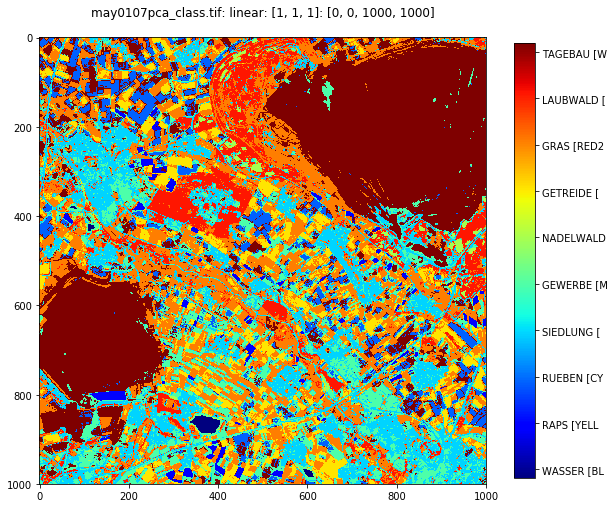

In [9]:
run scripts/dispms -f imagery/may0107pca_class.tif -c \
-r  "['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']" \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter6/fig6_5.eps'

### Gaussian kernel

In [ ]:
run scripts/classify -p [1,2,3,4] -a 2 -P imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/dispms -f imagery/may0107pca_class.tif -c \
-r "['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']"

In [ ]:
run scripts/dispms -f imagery/may0107pca_classprobs.tif -p [4,2,1] -e 1 \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter6/fig6_6.eps'

### Ffn with backpropagation

Training with NNet(Backprop)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 994.488902092
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.770420074463
thematic map written to: imagery/may0107pca_class.tif


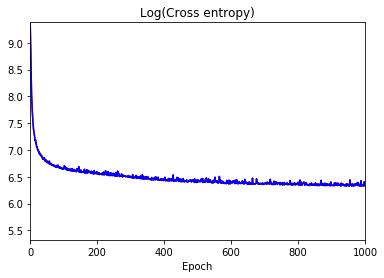

test results written to: imagery/may0107pca_NNet(Backprop).tst
done


In [2]:
run scripts/classify -p [1,2,3,4] -a 3 -e 1000 -L [10] imagery/may0107pca.tif imagery/train.shp

### Ffn with scaled conjugate gradiant

Training with NNet(Congrad)
reading training data...
training on 2399 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 14.5361549854
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.78102183342
thematic map written to: imagery/may0107pca_class.tif


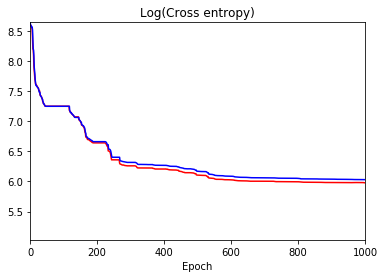

test results written to: imagery/may0107pca_NNet(Congrad).tst
done


In [3]:
run scripts/classify -p [1,2,3,4] -a 4 -e 1000 -L [10] -v imagery/may0107pca.tif imagery/train.shp

### Deep learning network

In [4]:
run scripts/classify -p [1,2,3,4] -a 6 -e 1000 -L [10,10,10] imagery/may0107pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 1.83982896805
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 5.79971289635
thematic map written to: imagery/may0107pca_class.tif
test results written to: imagery/may0107pca_Dnn(tensorflow).tst
done


In [14]:
run scripts/ct imagery/may0107pca_Dnn(tensorflow).tst

classification statistics
Dnn(tensorflow)test results for imagery/may0107pca.tif
Mon Apr 16 22:14:37 2018
Classification image: imagery/may0107pca_class.tif
Class probabilities image: None

Misclassification rate: 0.049069
Standard deviation: 0.004443
Conf. interval (95 percent): [0.041070 , 0.058533]
Kappa coefficient: 0.944480
Standard deviation: 0.005028
Contingency Table
[[  168.        0.        0.        0.        0.        0.        0.        0.        0.        0.      168.        1.   ]
 [    0.      152.        0.        0.        2.        0.        0.        0.        0.        0.      154.        0.987]
 [    0.        0.      258.        0.        0.        0.        0.        0.        0.        3.      261.        0.989]
 [    0.        0.        0.      266.       26.        0.        1.        2.        0.        0.      295.        0.902]
 [    0.        0.        0.        3.      214.        0.        0.        0.        0.        0.      217.        0.986]
 [    0

### Support Vector Machine

In [7]:
run scripts/classify -p [1,2,3,4] -a 7 imagery/may0107pca.tif imagery/train.shp

Training with SVM
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.456590175629
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 45.8794288635
thematic map written to: imagery/may0107pca_class.tif
test results written to: imagery/may0107pca_SVM.tst
done


In [8]:
run scripts/ct imagery/may0107pca_SVM.tst

classification statistics
SVMtest results for imagery/may0107pca.tif
Mon Apr 16 22:08:58 2018
Classification image: imagery/may0107pca_class.tif
Class probabilities image: None

Misclassification rate: 0.049915
Standard deviation: 0.004479
Conf. interval (95 percent): [0.041844 , 0.059448]
Kappa coefficient: 0.943446
Standard deviation: 0.005076
Contingency Table
[[  187.        0.        0.        0.        0.        0.        0.        0.        0.        0.      187.        1.   ]
 [    0.      146.        0.        0.        0.        0.        0.        0.        0.        0.      146.        1.   ]
 [    0.        0.      248.        0.        3.        0.        0.        0.        0.        0.      251.        0.988]
 [    0.        0.        0.      294.       24.        1.        0.        0.        0.        0.      319.        0.922]
 [    0.        1.        0.       10.      205.        0.        0.        0.        0.        0.      216.        0.949]
 [    0.        0. 

In [ ]:
# train a SVM  
classifier = ee.Classifier.svm(kernelType='RBF',gamma=0.01,cost=100)
trained = classifier.\
    train(trainData,'CLASS_ID',image.bandNames())

# classify the image and display    
classified = image.classify(trained)
url = classified.select('classification').\
    getThumbURL({'min':0,'max':9,'palette':jet})
disp.Image(url=url)